In [8]:
import tensorflow as tf

In [9]:
import matplotlib.pyplot as plt
import shutil
import os
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

In [10]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [11]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [12]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [13]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [14]:
batch_size = 32
seed = 42 

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [15]:
for text_batch,label_batch in raw_train_ds.take(1):
    for i in  range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [16]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [17]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [18]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [19]:
def customsdandardizer(text):
    to_lower = tf.strings.lower(text)
    remove_html = tf.strings.regex_replace(to_lower,'<br />','')
    return tf.strings.regex_replace(remove_html ,'[%s]' % re.escape(string.punctuation),'')

In [20]:
max_features = 10000
seq_length = 250

vectorizer = layers.TextVectorization(
    standardize = customsdandardizer,
    max_tokens = max_features,
    output_mode= 'int',
    output_sequence_length = seq_length
)

In [21]:
import re

train_text = raw_train_ds.map(lambda x,y:x)
vectorizer.adapt(train_text)

In [22]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorizer(text), label

In [23]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  257,    2,  222,    1,  574,   30,  227,   10, 2401,
           1,   52,   23,   25,  426,  248,   12,  306,  279,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [24]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
embedding_dim = 16

In [27]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [28]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [29]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 14s 21ms/step - loss: 0.6646 - binary_accuracy: 0.6918 - val_loss: 0.6181 - val_binary_accuracy: 0.7644
Epoch 2/10
625/625 [==============================] - 5s 9ms/step - loss: 0.5529 - binary_accuracy: 0.8002 - val_loss: 0.5034 - val_binary_accuracy: 0.8204
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4503 - binary_accuracy: 0.8432 - val_loss: 0.4256 - val_binary_accuracy: 0.8480
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3838 - binary_accuracy: 0.8632 - val_loss: 0.3790 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3406 - binary_accuracy: 0.8755 - val_loss: 0.3498 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3095 - binary_accuracy: 0.8873 - val_loss: 0.3305 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 6s 9ms

In [30]:
loss , accuracy = model.evaluate(test_ds)
print("loss :" ,loss)
print("accuracy :" , accuracy)

782/782 [==============================] - 25s 32ms/step - loss: 0.3146 - binary_accuracy: 0.8709
loss : 0.31456223130226135
accuracy : 0.8708800077438354


### For the model 1 we are going to increase the dropout value from 0.2 to 0.4

In [31]:
model1 = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.4),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [32]:
model1.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [33]:
epochs = 10
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 7s 10ms/step - loss: 0.6675 - binary_accuracy: 0.6813 - val_loss: 0.6228 - val_binary_accuracy: 0.7670
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5600 - binary_accuracy: 0.7951 - val_loss: 0.5115 - val_binary_accuracy: 0.8182
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4600 - binary_accuracy: 0.8375 - val_loss: 0.4346 - val_binary_accuracy: 0.8452
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3943 - binary_accuracy: 0.8576 - val_loss: 0.3871 - val_binary_accuracy: 0.8576
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3524 - binary_accuracy: 0.8707 - val_loss: 0.3575 - val_binary_accuracy: 0.8648
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3202 - binary_accuracy: 0.8818 - val_loss: 0.3373 - val_binary_accuracy: 0.8682
Epoch 7/10
625/625 [==============================] - 6s 9ms/

### For the model 2 we are going to change the activation function of dense layer from sigmoid to softmax

In [34]:
model2 = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='softmax')
])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [35]:
model2.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [36]:
epochs = 10
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 7s 9ms/step - loss: 0.6651 - binary_accuracy: 0.4981 - val_loss: 0.6179 - val_binary_accuracy: 0.5076
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5525 - binary_accuracy: 0.4981 - val_loss: 0.5028 - val_binary_accuracy: 0.5076
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4494 - binary_accuracy: 0.4981 - val_loss: 0.4250 - val_binary_accuracy: 0.5076
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3835 - binary_accuracy: 0.4981 - val_loss: 0.3784 - val_binary_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3408 - binary_accuracy: 0.4981 - val_loss: 0.3497 - val_binary_accuracy: 0.5076
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3097 - binary_accuracy: 0.4981 - val_loss: 0.3306 - val_binary_accuracy: 0.5076
Epoch 7/10
625/625 [==============================] - 5s 8ms/s

### Still now model 0 is the best performing model

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

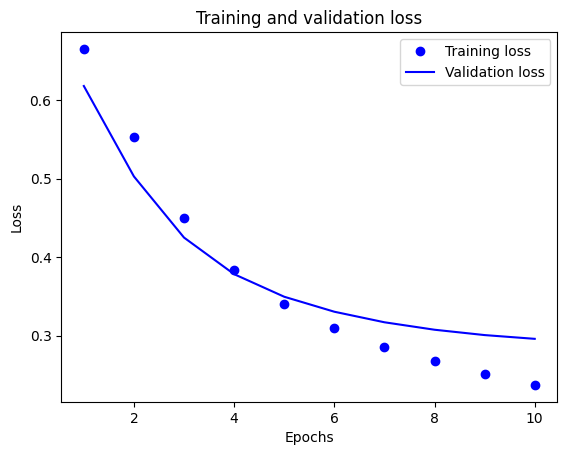

In [38]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### TEST using keras model tuner 

In [39]:
from tensorflow import keras

In [40]:
pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [41]:
import keras_tuner as kt

In [58]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(layers.Embedding(max_features, embedding_dim))

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(layers.Dropout(0.2))
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dropout(0.2))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  #model.add(keras.layers.Dense(10))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [59]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [60]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
text_batch_1, label_batch_1 = next(iter(train_ds))
text_batch_1[0]

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([9405,   15,   28,    5,    2,  240,   91,    5,   31,   60,    4,
          1, 1011,   36,  259,   37,    9, 3831,   35,    2,    1,   43,
        384, 5141,   16,    4, 1117,   12,   43, 5928,  297,    2,   86,
        225,   53, 3187, 3838,   20,  981,   18,   52,   53, 3187,  252,
        328,   34,   40, 4366,    3,  289,   60,   44,    6, 2862,    4,
       6664,   94,   23,  182,    2, 4895,  100, 1203,  337,  158, 1182,
       1469,    4,  814,  563,   30,    4,  846,  271,    3,  747,  747,
         50,  839,   30,   31, 2124,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [64]:
tuner.search(text_batch_1, label_batch_1, epochs=20, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.0001.



In [65]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(text_batch_1, label_batch_1, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6936 - accuracy: 0.4800 - val_loss: 0.6918 - val_accuracy: 0.5714
Epoch 2/10
1/1 [==============================] - 0s 71ms/step - loss: 0.6935 - accuracy: 0.4800 - val_loss: 0.6919 - val_accuracy: 0.8571
Epoch 3/10
1/1 [==============================] - 0s 76ms/step - loss: 0.6934 - accuracy: 0.5200 - val_loss: 0.6920 - val_accuracy: 0.8571
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.6934 - accuracy: 0.4800 - val_loss: 0.6921 - val_accuracy: 0.8571
Epoch 5/10
1/1 [==============================] - 0s 92ms/step - loss: 0.6934 - accuracy: 0.4400 - val_loss: 0.6922 - val_accuracy: 0.8571
Epoch 6/10
1/1 [==============================] - 0s 70ms/step - loss: 0.6933 - accuracy: 0.5200 - val_loss: 0.6923 - val_accuracy: 0.7143
Epoch 7/10
1/1 [==============================] - 0s 91ms/step - loss: 0.6930 - accuracy: 0.6000 - val_loss: 0.6924 - val_accuracy: 0.7143
Epoch 8/10
1/1 [=============